# Export Capstone Project: Model Training
#### Josh Barker
#### DTSC 691: Data Science Capstone: Applied Data Science
#### Eastern University
#### Spring 2025

## Exploratory Data Analysis Notebook Overview
We have already creating a cleaned dataset and chosen which variables to include. Now, it is time to train our machine learning models. We will train two sets of models: relationship identification and forecasting. The relationship identification models will be focused on predicting the present year’s export values given all of the present year’s data. The forecasting models will predict the present year's export values based on the prior year's data. 

In this notebook, we will:
* Import the `exports_data_final.csv` file from the Exploratory Data Analysis Notebook.
* Add lagged in the data for time-series training
* Train two sets of Linear Regression models
* Train two sets of Ridge Regression models
* Train two sets of Lasso Regression models
* Train two sets of RNNs
* Train two sets of LSTMs
* Evaluate model performance
* Save the best models

### Import Necessary Libraries
Below are all the libraries needed to run this notebook:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
import pickle

### Import data

In [2]:
raw_data = pd.read_csv("exports_data_final.csv")

In [3]:
raw_data.head()

,exports,log_exports,Year,MSA,Per_Capita_Income,Population,Manufacturing_Employment,Top_Corporate_Income_Tax_Rate,FHFA_index,avg_weather,energy_consumption,Minimum_Wage,S&P500_Close
0,28155182.0,17.153242,2005,"Abilene, TX",28776.0,160761.0,3.1,0.045,141.6100,63.350000,4825.0,5.15,1280.1
1,45615190.0,17.635751,2006,"Abilene, TX",30450.0,161389.0,3.3,0.045,153.6775,65.133333,4865.0,5.15,1438.2
2,53239613.0,17.790313,2007,"Abilene, TX",31933.0,162023.0,3.3,0.000,162.9025,62.158333,4895.0,5.15,1378.5
3,54420137.0,17.812245,2008,"Abilene, TX",35228.0,162508.0,3.3,0.000,166.1000,63.275000,4893.0,5.85,825.9
4,39196147.0,17.484089,2009,"Abilene, TX",33490.0,163888.0,3.0,0.000,169.7750,63.175000,4892.0,6.55,1073.9


### Finish Preprocessing Data with Lag
We will create a custom function to lag data. We will lag in both directions. 

For our relationship models, we want the previous year's exports and all of the current year's data to predict the current year's export volume. Custom function `lag_data` will provide us this.

For our forecasting models, we want the entirety of the previous year's data, including the previous year's export volume to predict the next year's export volume. Custom function `forecast_lag` will provide us this.

In [4]:
def lag_data(raw, column_to_lag):
    df = raw.copy()
    df["lagged_data"] = None
    
    for i in range(0, len(df)):
        year = df.loc[i, "Year"]
        msa = df.loc[i, "MSA"]
        if ((df["Year"] == year - 1) & (df["MSA"] == msa)).any() == True:
            df.loc[i, "lagged_data"] = df.loc[(df["Year"] == year - 1) & (df["MSA"] == msa)][column_to_lag].item()

    df["lagged_data"] = df["lagged_data"].astype(float)
    
    return df

In [5]:
#lag_data(df, "exports")

In [6]:
lagged_data = lag_data(raw_data, "exports")
lagged_data = lagged_data.rename(columns = {"lagged_data":"lagged_exports"})
lagged_data = lag_data(lagged_data, "log_exports")
lagged_data = lagged_data.rename(columns = {"lagged_data":"lagged_log_exports"})
lagged_data.head()

,exports,log_exports,Year,MSA,Per_Capita_Income,Population,Manufacturing_Employment,Top_Corporate_Income_Tax_Rate,FHFA_index,avg_weather,energy_consumption,Minimum_Wage,S&P500_Close,lagged_exports,lagged_log_exports
0,28155182.0,17.153242,2005,"Abilene, TX",28776.0,160761.0,3.1,0.045,141.6100,63.350000,4825.0,5.15,1280.1,NaN,NaN
1,45615190.0,17.635751,2006,"Abilene, TX",30450.0,161389.0,3.3,0.045,153.6775,65.133333,4865.0,5.15,1438.2,28155182.0,17.153242
2,53239613.0,17.790313,2007,"Abilene, TX",31933.0,162023.0,3.3,0.000,162.9025,62.158333,4895.0,5.15,1378.5,45615190.0,17.635751
3,54420137.0,17.812245,2008,"Abilene, TX",35228.0,162508.0,3.3,0.000,166.1000,63.275000,4893.0,5.85,825.9,53239613.0,17.790313
4,39196147.0,17.484089,2009,"Abilene, TX",33490.0,163888.0,3.0,0.000,169.7750,63.175000,4892.0,6.55,1073.9,54420137.0,17.812245


In [7]:
lagged_data = lagged_data.dropna()

In [8]:
def forecast_lag(raw, column_to_forecast):
    df = raw.copy()
    df["forecasted_data"] = None
    
    for i in range(0, len(df)):
        year = df.loc[i, "Year"]
        msa = df.loc[i, "MSA"]
        if ((df["Year"] == year + 1) & (df["MSA"] == msa)).any() == True:
            df.loc[i, "forecasted_data"] = df.loc[(df["Year"] == year + 1) & (df["MSA"] == msa)][column_to_forecast].item()

    df["forecasted_data"] = df["forecasted_data"].astype(float)

    return df

In [9]:
forecast_data = forecast_lag(raw_data, "exports")
forecast_data = forecast_data.rename(columns = {"forecasted_data":"next_year_exports"})
forecast_data = forecast_lag(forecast_data, "log_exports")
forecast_data = forecast_data.rename(columns = {"forecasted_data":"next_year_log_exports"})
forecast_data = forecast_data.dropna()
forecast_data = forecast_data[['exports', 'Year', 'MSA', 'Per_Capita_Income', 'Population', 'Manufacturing_Employment','Top_Corporate_Income_Tax_Rate', 'FHFA_index', 'avg_weather','energy_consumption', 'Minimum_Wage', 'S&P500_Close','next_year_exports', 'next_year_log_exports', 'log_exports']]
forecast_data.head()

,exports,Year,MSA,Per_Capita_Income,Population,Manufacturing_Employment,Top_Corporate_Income_Tax_Rate,FHFA_index,avg_weather,energy_consumption,Minimum_Wage,S&P500_Close,next_year_exports,next_year_log_exports,log_exports
0,28155182.0,2005,"Abilene, TX",28776.0,160761.0,3.1,0.045,141.6100,63.350000,4825.0,5.15,1280.1,45615190.0,17.635751,17.153242
1,45615190.0,2006,"Abilene, TX",30450.0,161389.0,3.3,0.045,153.6775,65.133333,4865.0,5.15,1438.2,53239613.0,17.790313,17.635751
2,53239613.0,2007,"Abilene, TX",31933.0,162023.0,3.3,0.000,162.9025,62.158333,4895.0,5.15,1378.5,54420137.0,17.812245,17.790313
3,54420137.0,2008,"Abilene, TX",35228.0,162508.0,3.3,0.000,166.1000,63.275000,4893.0,5.85,825.9,39196147.0,17.484089,17.812245
4,39196147.0,2009,"Abilene, TX",33490.0,163888.0,3.0,0.000,169.7750,63.175000,4892.0,6.55,1073.9,46792118.0,17.661225,17.484089


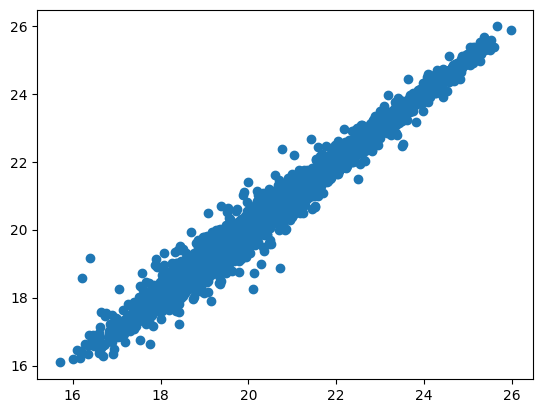

In [10]:
plt.scatter(x = "log_exports", y = "next_year_log_exports", data = forecast_data)
plt.show()

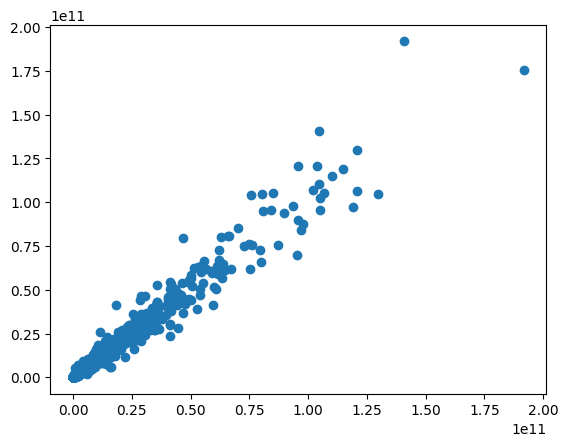

In [11]:
plt.scatter(x = "exports", y = "next_year_exports", data = forecast_data)
plt.show()

## Train Models

### Train-Test Split
Now, we should separate our training data into the training test and the test set. We will use a random state to ensure the output remains the same as the code is rerun. 

In [12]:
lagged_data_train, lagged_data_test = train_test_split(lagged_data, test_size = 0.2, random_state = 1, shuffle = False)

In [13]:
forecast_data_train, forecast_data_test = train_test_split(forecast_data, test_size = 0.2, random_state = 1, shuffle = False)

Now, we should separate our X and Y features. If we we are training our linear models on the log(exports)--in order to maintain a normal distribution of the output variable--we should remove the normal export variables, as well as the non-numeric metro area text and the year.

In [14]:
lagged_data_train.head(2)

,exports,log_exports,Year,MSA,Per_Capita_Income,Population,Manufacturing_Employment,Top_Corporate_Income_Tax_Rate,FHFA_index,avg_weather,energy_consumption,Minimum_Wage,S&P500_Close,lagged_exports,lagged_log_exports
1,45615190.0,17.635751,2006,"Abilene, TX",30450.0,161389.0,3.3,0.045,153.6775,65.133333,4865.0,5.15,1438.2,28155182.0,17.153242
2,53239613.0,17.790313,2007,"Abilene, TX",31933.0,162023.0,3.3,0.000,162.9025,62.158333,4895.0,5.15,1378.5,45615190.0,17.635751


In [15]:
lag_x_train = lagged_data_train.drop(["exports", "log_exports", "Year", "MSA", "lagged_exports"], axis = 1)
lag_y_train = lagged_data_train["log_exports"]
lag_x_test = lagged_data_test.drop(["exports", "log_exports", "Year", "MSA", "lagged_exports"], axis = 1)
lag_y_test = lagged_data_test["log_exports"]

In [16]:
forecast_x_train = forecast_data_train.drop(["exports", "Year", "MSA", "next_year_exports", "next_year_log_exports"], axis = 1)
forecast_y_train = forecast_data_train["next_year_log_exports"]
forecast_x_test = forecast_data_test.drop(["exports", "Year", "MSA", "next_year_exports", "next_year_log_exports"], axis = 1)
forecast_y_test = forecast_data_test["next_year_log_exports"]

### Linear Models
We will begin by training 3 types of linear models with a single year lag:
* Autoregressive Linear Regression
* Ridge Regression
* Lasso Regression

In [17]:
lag_linear_model = LinearRegression()
lag_linear_model.fit(lag_x_train, lag_y_train)

LinearRegression()

In [18]:
forecast_linear_model = LinearRegression()
forecast_linear_model.fit(forecast_x_train, forecast_y_train)

LinearRegression()

In [19]:
lag_ridge_model = Ridge()
lag_ridge_model.fit(lag_x_train, lag_y_train)

Ridge()

In [20]:
forecast_ridge_model = Ridge()
forecast_ridge_model.fit(forecast_x_train, forecast_y_train)

Ridge()

In [21]:
lag_lasso_model = Lasso()
lag_lasso_model.fit(lag_x_train, lag_y_train)

Lasso()

In [22]:
forecast_lasso_model = Lasso()
forecast_lasso_model.fit(forecast_x_train, forecast_y_train)

Lasso()

We can see the overview statistics of the Linear model's performance by replicating the model using statsmodel regression summary. See the coefficients for both linear models are identicial from the Sci-kit Learn regression and Statsmodel regression. We can see that both models have an R-squared of 0.98, which is very high. This means that the model is quite predictive. 

Not surprisingly, the vast majority of the predictive power comes from the lagged value (last period exports for the relationship model and current period exports for the forecast model). 

Using p-values, we can see for the relationship linear model, the following variables are statistically significant:
* at alpha = 0.01 : lagged_log_exports, Minimum_Wage, FHFA_index
* at alpha = 0.05 : lagged_log_exports, Minimum_Wage, FHFA_index, Per_Capita_Income, Manufacturing_Employment
* at alpha = 0.1 : lagged_log_exports, Minimum_Wage, FHFA_index, Per_Capita_Income, Manufacturing_Employment, Top_Corporate_Income_Tax_Rate

Using p-values, we can see for the forecasting linear model, the following variables are statistically significant:
* at alpha = 0.01 : log_exports, Per_Capita_Income, Minimum_Wage, S&P500_Close
* at alpha = 0.05 : log_exports, Per_Capita_Income, Minimum_Wage, S&P500_Close, FHFA_index
* at alpha = 0.1 :  log_exports, Per_Capita_Income, Minimum_Wage, S&P500_Close, FHFA_index

In [23]:
print(lag_linear_model.intercept_)
print(lag_linear_model.coef_)

0.20795663966021039
[-7.68872705e-07 -1.32630576e-09  2.99810321e-04  4.14009651e-02
  2.93162315e-04  1.94843685e-03  9.40472146e-06 -1.05653696e-02
 -3.01745631e-06  9.86458911e-01]


In [24]:
model = sm.OLS(lag_y_train,sm.add_constant(lag_x_train.astype(float)))
regression = model.fit()
print(regression.summary(title = "Lagged Regression Model"))

                           Lagged Regression Model                            
Dep. Variable:            log_exports   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 2.234e+04
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:19:44   Log-Likelihood:                 114.48
No. Observations:                4336   AIC:                            -207.0
Df Residuals:                    4325   BIC:                            -136.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [25]:
print(forecast_linear_model.intercept_)
print(forecast_linear_model.coef_)

0.4597179581078521
[-1.67986818e-06  5.66979805e-09  1.13474065e-04  9.47944606e-03
  1.42095179e-04 -2.50918447e-04 -7.14544187e-06 -1.45720823e-02
  1.87699496e-05  9.87469348e-01]


In [26]:
model = sm.OLS(forecast_y_train.astype(float), sm.add_constant(forecast_x_train))
regression = model.fit()
print(regression.summary(title = "Forecasted Regression Model"))

                           Forecasted Regression Model                           
Dep. Variable:     next_year_log_exports   R-squared:                       0.981
Model:                               OLS   Adj. R-squared:                  0.981
Method:                    Least Squares   F-statistic:                 2.240e+04
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                           15:19:45   Log-Likelihood:                 119.97
No. Observations:                   4336   AIC:                            -217.9
Df Residuals:                       4325   BIC:                            -147.8
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In comparing the coefficients from the linear models. Recall that the Ridge Regression adds a penalty--or regularization term--to the least squares minimization to reduce overfitting and the Lasso Regression's cost function allows coefficients to approach 0 for terms that it identifies as not contributing to the output. 

For both the relationship models, the Ridge regression coefficients are very similar to the Linear Regression. The Lasso Regression eliminates the Top_Corporate_Income_Tax_Rate, avg_weather, and Minimum_Wage variables, as well as greatly reducing the impact of the lagged_log_exports. It gives a greater weight to Population, energy_consumption, and Manufacturing_Employment than the other two models. Unlike the Linear and Ridge models which assigns a positve weight to the FHFA_index and energy_consumption, the Lasso regression assigns a larger (in aboslute value) negative weight to both features. 

In [27]:
linear_lag_coefficients = pd.DataFrame({"Feature":lag_x_train.columns, "Linear":lag_linear_model.coef_, "Ridge":lag_ridge_model.coef_,"Lasso":lag_lasso_model.coef_})
linear_lag_coefficients

,Feature,Linear,Ridge,Lasso
0,Per_Capita_Income,-7.688727e-07,-7.662208e-07,1.231667e-05
1,Population,-1.326306e-09,-1.317049e-09,9.422237e-08
2,Manufacturing_Employment,2.998103e-04,3.021213e-04,7.593245e-03
3,Top_Corporate_Income_Tax_Rate,4.140097e-02,3.242166e-02,0.000000e+00
4,FHFA_index,2.931623e-04,2.922991e-04,-2.353858e-03
5,avg_weather,1.948437e-03,1.939540e-03,0.000000e+00
6,energy_consumption,9.404721e-06,9.361911e-06,-5.016527e-05
7,Minimum_Wage,-1.056537e-02,-1.054423e-02,-0.000000e+00
8,S&P500_Close,-3.017456e-06,-3.021477e-06,4.883597e-05
9,lagged_log_exports,9.864589e-01,9.863236e-01,3.878929e-01


In [28]:
linear_forecast_coefficients = pd.DataFrame({"Feature":forecast_x_train.columns, "Linear":forecast_linear_model.coef_, "Ridge":forecast_ridge_model.coef_, "Lasso":forecast_lasso_model.coef_})
linear_forecast_coefficients

,Feature,Linear,Ridge,Lasso
0,Per_Capita_Income,-1.679868e-06,-1.676343e-06,1.303663e-05
1,Population,5.669798e-09,5.678356e-09,1.020118e-07
2,Manufacturing_Employment,1.134741e-04,1.156539e-04,7.228379e-03
3,Top_Corporate_Income_Tax_Rate,9.479446e-03,7.544736e-03,0.000000e+00
4,FHFA_index,1.420952e-04,1.412808e-04,-2.722445e-03
5,avg_weather,-2.509184e-04,-2.482253e-04,0.000000e+00
6,energy_consumption,-7.145442e-06,-7.141228e-06,-5.579809e-05
7,Minimum_Wage,-1.457208e-02,-1.455916e-02,-0.000000e+00
8,S&P500_Close,1.876995e-05,1.877208e-05,5.676928e-05
9,log_exports,9.874693e-01,9.873296e-01,3.900188e-01


### RNN Models
Now, we will turn to training the RNN models: a pure Recurrent Neural Network and a Long Short-Term Memory (LSTM) Recurrent Neural Network. For our RNN Models, we will take 25% of the test set and use it for a validation set in training. 

One of the limitations of the RNN is that we need to process the data differently. For training purposes, we need the length of each entry to be the same.

In [29]:
lag_x_test_rnn, lag_x_validation, lag_y_test_rnn, lag_y_validation = train_test_split(lag_x_test, lag_y_test, test_size = 0.25, random_state = 1)
forecast_x_test_rnn, forecast_x_validation, forecast_y_test_rnn, forecast_y_validation = train_test_split(forecast_x_test, forecast_y_test, test_size = 0.25, random_state = 1)

In [30]:
lag_rnn_model = Sequential()
lag_rnn_model.add(Dense(10, input_shape=(10, 1)))
lag_rnn_model.add(SimpleRNN(32, activation = "tanh"))
lag_rnn_model.add(Dense(1))
lag_rnn_model.compile(loss = "mean_squared_error", optimizer = "adam")

hist_rnn_lag = lag_rnn_model.fit(lag_x_train, lag_y_train, validation_data = (lag_x_validation, lag_y_validation), epochs = 50)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 322.6790 - val_loss: 131.1340
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 119.2561 - val_loss: 64.2888
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 59.2785 - val_loss: 28.1849
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 27.6130 - val_loss: 11.2755
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 11.8393 - val_loss: 4.6188
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 6.1358 - val_loss: 2.5590
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3.7306 - val_loss: 2.1161
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 3.0604 - val_loss: 2.1049
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 2.9833 - val_loss: 2.0668
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 2.8135 - val_loss: 1.3438
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1.8347 - val_loss: 0.8897
Epoch 12/50
136/136 ━━━━━━━━━━━

In [31]:
forecast_rnn_model = Sequential()
forecast_rnn_model.add(Dense(10, input_shape=(10, 1), activation = "relu"))
forecast_rnn_model.add(SimpleRNN(32, activation = "tanh", input_shape = (10, 1)))
forecast_rnn_model.add(Dense(1))
forecast_rnn_model.compile(loss = "MeanSquaredError", optimizer = "adam")

hist_rnn_lag = forecast_rnn_model.fit(forecast_x_train, forecast_y_train, validation_data = (forecast_x_validation, forecast_y_validation), epochs = 50)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 310.4967 - val_loss: 123.3788
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 112.4548 - val_loss: 58.9647
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 54.9138 - val_loss: 24.8590
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 24.1630 - val_loss: 9.7621
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 10.5558 - val_loss: 4.0696
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 5.1571 - val_loss: 2.2685
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 3.3891 - val_loss: 1.5090
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 2.2061 - val_loss: 1.0271
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 1.5969 - val_loss: 0.7912
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 1.2892 - val_loss: 0.5599
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.8902 - val_loss: 0.3524
Epoch 12/50
136/136 ━━━━━━━━━━━━

In [32]:
#Create the LSTM model
lag_lstm_model = Sequential()
lag_lstm_model.add(LSTM(128, activation = "tanh", recurrent_activation = "sigmoid", input_shape=(10, 1)))
lag_lstm_model.add(Dense(1))
lag_lstm_model.compile(loss = "mean_squared_error", optimizer = "adam")

#Train the LSTM model
hist_lstm_lag = lag_lstm_model.fit(lag_x_train, lag_y_train, validation_data = (lag_x_validation, lag_y_validation), epochs = 50)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 222.0297 - val_loss: 2.1238
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8522 - val_loss: 2.2039
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7266 - val_loss: 1.4619
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5731 - val_loss: 0.4569
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5448 - val_loss: 0.2318
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3236 - val_loss: 0.1663
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2109 - val_loss: 0.1182
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1615 - val_loss: 0.2196
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1348 - val_loss: 0.1058
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1191 - val_loss: 0.0910
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1085 - val_loss: 0.0842
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 

In [33]:
#Create the LSTM model
forecast_lstm_model = Sequential()
forecast_lstm_model.add(LSTM(128, activation = "tanh", recurrent_activation = "sigmoid", input_shape=(10, 1)))
forecast_lstm_model.add(Dense(1))
forecast_lstm_model.compile(loss = "mean_squared_error", optimizer = "adam")

#Train the LSTM model
hist_lstm_forecast = forecast_lstm_model.fit(forecast_x_train, forecast_y_train, validation_data = (forecast_x_validation, forecast_y_validation), epochs = 50)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 185.7330 - val_loss: 2.2906
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8673 - val_loss: 1.8916
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4865 - val_loss: 1.4365
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2714 - val_loss: 0.2868
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3749 - val_loss: 0.1666
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2348 - val_loss: 0.1380
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1671 - val_loss: 0.0945
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1288 - val_loss: 0.0842
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1045 - val_loss: 0.0866
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0905 - val_loss: 0.0803
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0832 - val_loss: 0.0861
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

## Measuring Accuracy
Now, we can turn to measuring accuracy. Since this is a regression model, we can evaluate the $R^2$ and $MSE$ of each model. Because $R^2$ is equivalent to $1 - \frac{SSE}{SST}$ and $MSE = \frac{SSE}{n}$, there is a direct inverse relationship between the two metrics. We want the model with the highest $R^2$ or the lowest $MSE$.

In [34]:
#Recall our model details
lag_models = [lag_linear_model, lag_ridge_model, lag_lasso_model, lag_rnn_model, lag_lstm_model]
forecast_models = [forecast_linear_model, forecast_ridge_model, forecast_lasso_model, forecast_rnn_model, forecast_lstm_model]

model_names = ["linear", "ridge", "lasso", "rnn", "lstm"]

In [35]:
lag_linear_preds = lag_linear_model.predict(lag_x_test)
lag_ridge_preds = lag_ridge_model.predict(lag_x_test)
lag_lasso_preds = lag_lasso_model.predict(lag_x_test)
lag_rnn_preds = lag_rnn_model.predict(lag_x_test_rnn)
lag_lstm_preds = lag_lstm_model.predict(lag_x_test_rnn)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [36]:
print("Lag Model R2 with Log Exports")
print("Linear R2:", r2_score(lag_y_test, lag_linear_preds))
print("Ridge R2:", r2_score(lag_y_test, lag_ridge_preds))
print("Lasso R2:", r2_score(lag_y_test, lag_lasso_preds))
print("RNN R2:", r2_score(lag_y_test_rnn, lag_rnn_preds))
print("LSTM R2:", r2_score(lag_y_test_rnn, lag_lstm_preds))

Lag Model R2 with Log Exports
Linear R2: 0.9698814907710049
Ridge R2: 0.9698808130618417
Lasso R2: 0.7622398107153241
RNN R2: 0.9691854909400158
LSTM R2: 0.964134153750546


When evaluating model performance, we can see that the Linear Regression has the highest $R_2$, but all of the models--except for the Lasso Regression have very strong performance. However, recall that the output the model provides is in the predicted log of exports. Now, let's see how (or if) this changes when we convert our predicted values back into export volumes--inversing the log transform.

In [37]:
lag_y_test_exports = lagged_data.loc[lag_y_test.index]["exports"]
lag_y_test_exports_rnn = lagged_data.loc[lag_y_test_rnn.index]["exports"]

In [38]:
print("Lag Model R2 with Raw Exports")
print("Linear R2:", r2_score(lag_y_test_exports, np.exp(lag_linear_preds)))
print("Ridge R2:", r2_score(lag_y_test_exports, np.exp(lag_ridge_preds)))
print("Lasso R2:", r2_score(lag_y_test_exports, np.exp(lag_lasso_preds)))
print("RNN R2:", r2_score(lag_y_test_exports_rnn, np.exp(lag_rnn_preds)))
print("LSTM R2:", r2_score(lag_y_test_exports_rnn, np.exp(lag_lstm_preds)))

Lag Model R2 with Raw Exports
Linear R2: 0.9660890843328535
Ridge R2: 0.9660859556024769
Lasso R2: 0.5786109184805173
RNN R2: 0.9567716705628571
LSTM R2: 0.9191538594186801


Here, the Linear Regression remains the best performer; however, notably the RNN model goes from performing slightly better than the LSTM to slightly worse. Still, the Lasso Regression remains the worst performing. Unsurpisingly, when we consider the MSE, rather than $R^2$, the order and results are the same.

In [39]:
print("Lag Model Mean Squared Error with Log Exports")
print("Linear MSE:", mean_squared_error(lag_y_test, lag_linear_preds))
print("Ridge MSE:", mean_squared_error(lag_y_test, lag_ridge_preds))
print("Lasso MSE:", mean_squared_error(lag_y_test, lag_lasso_preds))
print("RNN MSE:", mean_squared_error(lag_y_test_rnn, lag_rnn_preds))
print("LSTM MSE:", mean_squared_error(lag_y_test_rnn, lag_lstm_preds))
print("-----------------------------------------------")
print("Lag Model Mean Squared Error with Raw Exports")
print("Linear MSE:", mean_squared_error(lag_y_test_exports, np.exp(lag_linear_preds)))
print("Ridge MSE:", mean_squared_error(lag_y_test_exports, np.exp(lag_ridge_preds)))
print("Lasso MSE:", mean_squared_error(lag_y_test_exports, np.exp(lag_lasso_preds)))
print("RNN MSE:", mean_squared_error(lag_y_test_exports_rnn, np.exp(lag_rnn_preds)))
print("LSTM MSE:", mean_squared_error(lag_y_test_exports_rnn, np.exp(lag_lstm_preds)))

Lag Model Mean Squared Error with Log Exports
Linear MSE: 0.05980820000743808
Ridge MSE: 0.05980954577674137
Lasso MSE: 0.47213521912481127
RNN MSE: 0.060046406590725195
LSTM MSE: 0.06988964784163437
-----------------------------------------------
Lag Model Mean Squared Error with Raw Exports
Linear MSE: 1.4155631864588495e+18
Ridge MSE: 1.4156937908808822e+18
Lasso MSE: 1.7590290891277468e+19
RNN MSE: 1.6853615283984412e+18
LSTM MSE: 3.151983359740353e+18


Now, let's turn to the forecast model performance.

In [40]:
forecast_linear_preds = forecast_linear_model.predict(forecast_x_test)
forecast_ridge_preds = forecast_ridge_model.predict(forecast_x_test)
forecast_lasso_preds = forecast_lasso_model.predict(forecast_x_test)
forecast_rnn_preds = forecast_rnn_model.predict(forecast_x_test_rnn)
forecast_lstm_preds = forecast_lstm_model.predict(forecast_x_test_rnn)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [41]:
print("Forecast Model R2 with Log Exports")
print("Linear R2:", r2_score(forecast_y_test, forecast_linear_preds))
print("Ridge R2:", r2_score(forecast_y_test, forecast_ridge_preds))
print("Lasso R2:", r2_score(forecast_y_test, forecast_lasso_preds))
print("RNN R2:", r2_score(forecast_y_test_rnn, forecast_rnn_preds))
print("LSTM R2:", r2_score(forecast_y_test_rnn, forecast_lstm_preds))

Forecast Model R2 with Log Exports
Linear R2: 0.9701044709885537
Ridge R2: 0.9701063508444733
Lasso R2: 0.760707887782838
RNN R2: 0.9667158677278009
LSTM R2: 0.9708664215791677


For the forecast model, we find that the LSTM model is the best performer, while the others are just narrowly behind it when looking at the prediction of log exports, though our top 4 models are all much closer to each other than in the lag models. However, what happens when we inverse the log transform?

In [42]:
forecast_y_test_exports = forecast_data.loc[forecast_y_test.index]["exports"]
forecast_y_test_exports_rnn = forecast_data.loc[forecast_y_test_rnn.index]["exports"]

In [43]:
print("Forecast Model R2 with Raw Exports")
print("Linear R2:", r2_score(forecast_y_test_exports, np.exp(forecast_linear_preds)))
print("Ridge R2:", r2_score(forecast_y_test_exports, np.exp(forecast_ridge_preds)))
print("Lasso R2:", r2_score(forecast_y_test_exports, np.exp(forecast_lasso_preds)))
print("RNN R2:", r2_score(forecast_y_test_exports_rnn, np.exp(forecast_rnn_preds)))
print("LSTM R2:", r2_score(forecast_y_test_exports_rnn, np.exp(forecast_lstm_preds)))

Forecast Model R2 with Raw Exports
Linear R2: 0.9986241142797531
Ridge R2: 0.9986214895063257
Lasso R2: 0.5750238377807895
RNN R2: 0.9876398637186499
LSTM R2: 0.9937929464131029


We find, somewhat surprisingly, that after inversing the log transform, the Linear Regression and Ridge Regression both surpass the LSTM model's performance. These relationships remain true when examining the MSE below. 

In [44]:
print("Forecast Model Mean Squared Error with Log Exports")
print("Linear MSE:", mean_squared_error(forecast_y_test, forecast_linear_preds))
print("Ridge MSE:", mean_squared_error(forecast_y_test, forecast_ridge_preds))
print("Lasso MSE:", mean_squared_error(forecast_y_test, forecast_lasso_preds))
print("RNN MSE:", mean_squared_error(forecast_y_test_rnn, forecast_rnn_preds))
print("LSTM MSE:", mean_squared_error(forecast_y_test_rnn, forecast_lstm_preds))
print("-----------------------------------------------")
print("Forecast Model Mean Squared Error with Raw Exports")
print("Linear MSE:", mean_squared_error(forecast_y_test_exports, np.exp(forecast_linear_preds)))
print("Ridge MSE:", mean_squared_error(forecast_y_test_exports, np.exp(forecast_ridge_preds)))
print("Lasso MSE:", mean_squared_error(forecast_y_test_exports, np.exp(forecast_lasso_preds)))
print("RNN MSE:", mean_squared_error(forecast_y_test_exports_rnn, np.exp(forecast_rnn_preds)))
print("LSTM MSE:", mean_squared_error(forecast_y_test_exports_rnn, np.exp(forecast_lstm_preds)))

Forecast Model Mean Squared Error with Log Exports
Linear MSE: 0.05936541429890702
Ridge MSE: 0.05936168135190206
Lasso MSE: 0.4751772539229315
RNN MSE: 0.0648588149025979
LSTM MSE: 0.05677087672870984
-----------------------------------------------
Forecast Model Mean Squared Error with Raw Exports
Linear MSE: 5.657085531656278e+16
Ridge MSE: 5.667877538260795e+16
Lasso MSE: 1.747330074882644e+19
RNN MSE: 4.7648297535057683e+17
LSTM MSE: 2.392817760195553e+17


### Save Best Model
Because we are working to predict raw export volumes, I will select the two models that perform the best with the export predictions, which end up being the least complex of the models--the Linear Regression.

In [45]:
best_lag_model = lag_linear_model
best_forecast_model = forecast_linear_model

In [46]:
pickle.dump(best_lag_model, open('best_lag_model.pkl', 'wb'))
pickle.dump(best_forecast_model, open('best_forecast_model.pkl', 'wb'))